In [1]:
%config InlineBackend.figure_format = 'retina'
import torch
import pickle
import graph_generation
import numpy as np

In [2]:
graphs, metadata = graph_generation.community_sbm.load_community_dataset("data/community_sbm/params_2_30_0.8_0.02_8/graphs.pkl")

In [3]:
import numpy as np

perm = np.random.permutation(graphs[0].adj.shape[0])

In [4]:
perm

array([ 7, 13,  4,  9, 21, 25, 27, 19, 28,  1,  6, 29, 23, 12, 24, 15,  8,
        5, 11,  2, 22, 26, 14,  0, 18, 17,  3, 10, 16, 20])

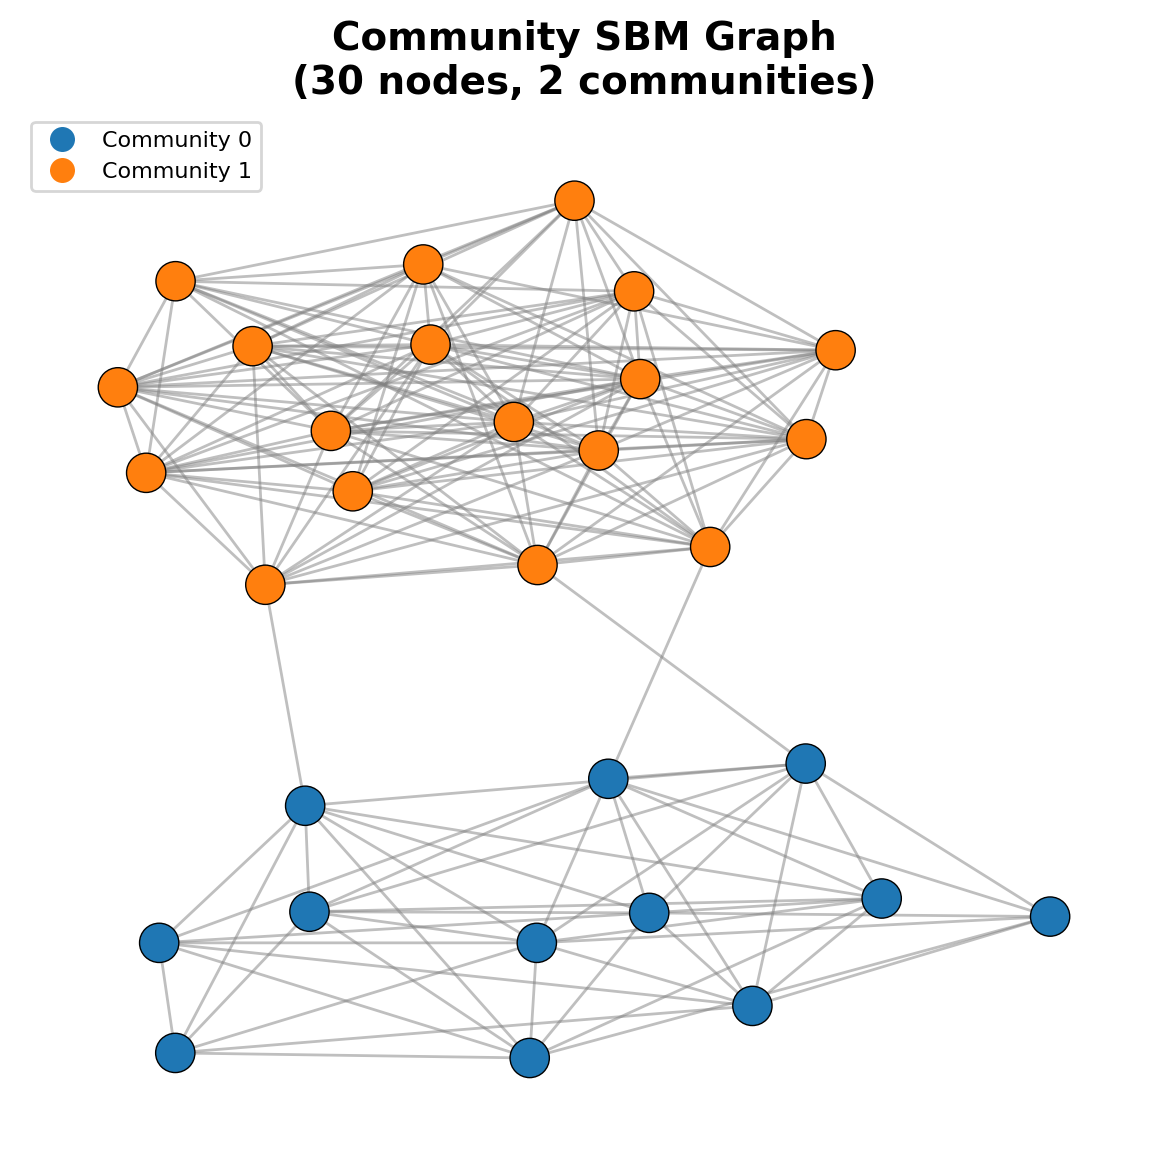

In [5]:
gg = graphs[1]
gg.adj = gg.adj[perm,:]
gg.adj = gg.adj[:,perm]
gg.node_features = gg.node_features[perm,:]
#_ = graph_generation.visualization.show_community_graph(graphs[1])
_ = graph_generation.visualization.show_community_graph(gg)

In [4]:
import os
import time
import pickle
import numpy as np
import torch
from tqdm import tqdm

from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.samplers import MHSamplerFeatures, GraphTuple, ChimeraSamplerFeatures

def basic_observables(graph_tuple: GraphTuple) -> torch.Tensor:

    mtx = graph_tuple.adj
    feat = graph_tuple.node_features

    nn = torch.sum(feat,axis=0)
    mm = (feat.T) @ mtx @ feat
    #val = 10 * mm[0,0]/torch.sum(feat, axis = 0)[0]
    indices = torch.triu_indices(mm.shape[0], mm.shape[1], offset=1)

    vals = mm[indices[0], indices[1]]
    mm = mm / nn

    in_community = torch.prod(torch.diag(mm))
    out_community = -torch.prod(vals)
    edges = torch.sum(mtx) / 2
    triangles = torch.trace(mtx @ mtx @ mtx) / 6

    list_obs = []
    for number in nn:
        list_obs.append(number)
    list_obs.append(in_community)
    list_obs.append(out_community)
    list_obs.append(edges)
    list_obs.append(triangles)
    return torch.stack(list_obs)

#class MySampler(MHSamplerFeatures):
class MySampler(ChimeraSamplerFeatures):
    def __init__(self, p_edge = 0.8, backend = "cpu"):
        super().__init__(p_edge = p_edge, backend = backend)
    def observables(self, graph_tuple): 
        return basic_observables(graph_tuple)


In [5]:
test_obs = basic_observables(graphs[1])
test_obs

tensor([ 12.0000,  18.0000, 109.6667,  -3.0000, 176.0000, 535.0000])

In [6]:

sampler = MySampler()

In [7]:

graph = graphs[1]
obs   = sampler.observables(graph)
#params = torch.Tensor([0., 0., 0., 0., 0., 0.])
params = torch.zeros_like(test_obs)
niter  = 500000
params_update_every = 5
save_every = 250
alpha = 0.0002
min_change = 0.001
tot_accept = 1000000

params_hist, graph_hist = sampler.param_run(
    graph=graph,
    observables=obs,
    params=params,
    niter=niter,
    params_update_every=params_update_every,
    save_every=save_every,
    save_params=True,
    alpha=alpha,
    min_change=min_change,
    tot_accept=tot_accept,
    verbose_level=0
)

params_final = params_hist[-1]
print(params_final)

return_obs, return_graph = sampler.sample_run(
    graph=graph,
    params=params_final,
    niter=100000,
    save_every=save_every,
    burn_in=0.3
)

final_params = params_hist[-1]

# sampler.param_run already prints accepted/rejected
# but we try to extract them from attributes if present
accepted = getattr(sampler, "accepted_steps", None)
rejected = getattr(sampler, "rejected_samples", None)
acc_rate = (accepted / niter) if accepted is not None else None


100%|██████████| 500000/500000 [10:11<00:00, 818.11it/s]


number of accepted steps is:  332929
number of rejected samples:  167071
number of effective updates is:  66585
tensor([ 0.0024, -0.0024,  1.7181,  0.4013, -1.8807,  0.0962])


100%|██████████| 100000/100000 [01:28<00:00, 1135.32it/s]

number of accepted steps is:  19733
number of rejected samples:  80267
Mean obs:  tensor([ 12.0000,  18.0000, 179.6063,  -3.0199, 216.0430, 945.6656])


<Figure size 640x480 with 0 Axes>

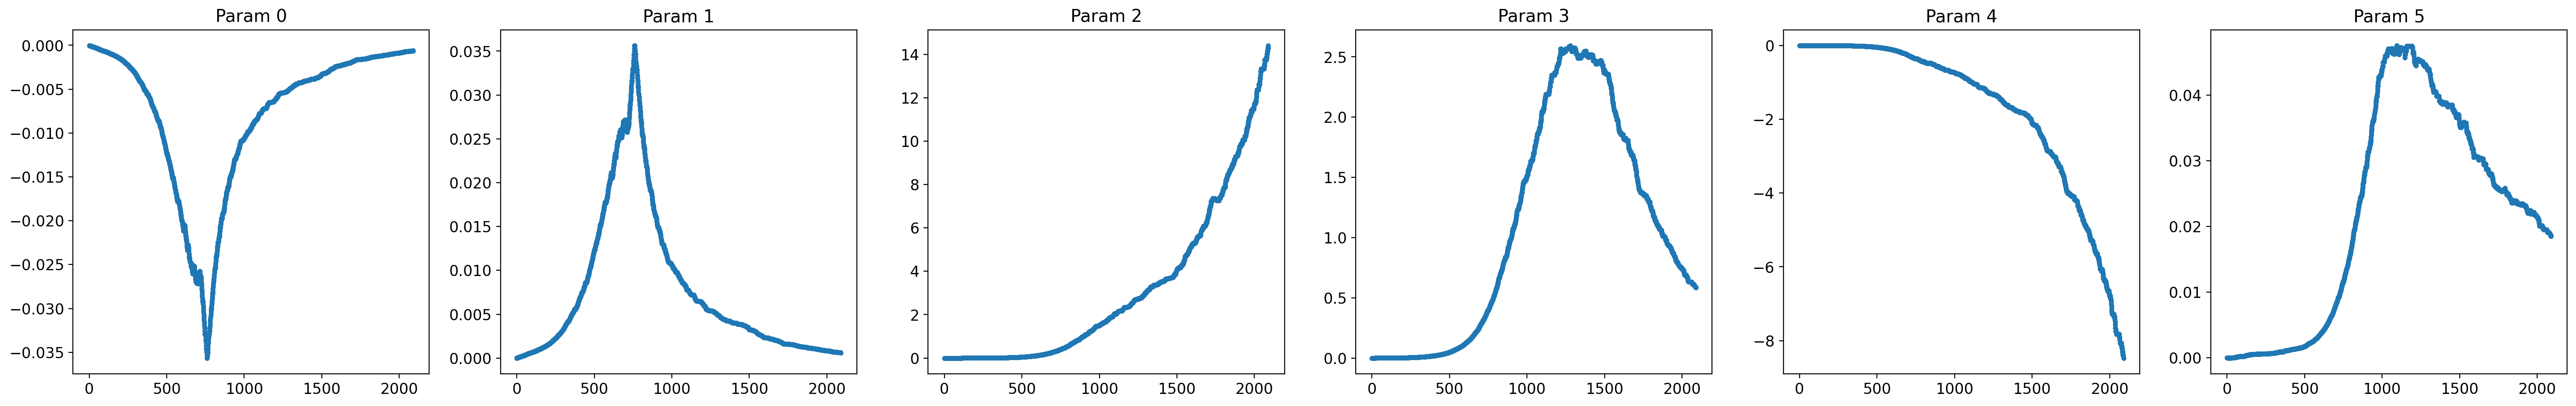

In [ ]:

import matplotlib.pyplot as plt

pp = torch.stack(params_hist).numpy()
n_params = pp.shape[1]
height = 5
width = 6
plt.tight_layout()
plt.figure(figsize = (width * n_params, height))

for i in range(n_params):
    plt.subplot(1,n_params, i + 1)
    plt.title(f"Param {i}")
    plt.plot(pp[:,i], ".-")


In [ ]:
_ = graph_generation.visualization.show_community_graph(return_graph[-13], layout="spring")

IndexError: list index out of range

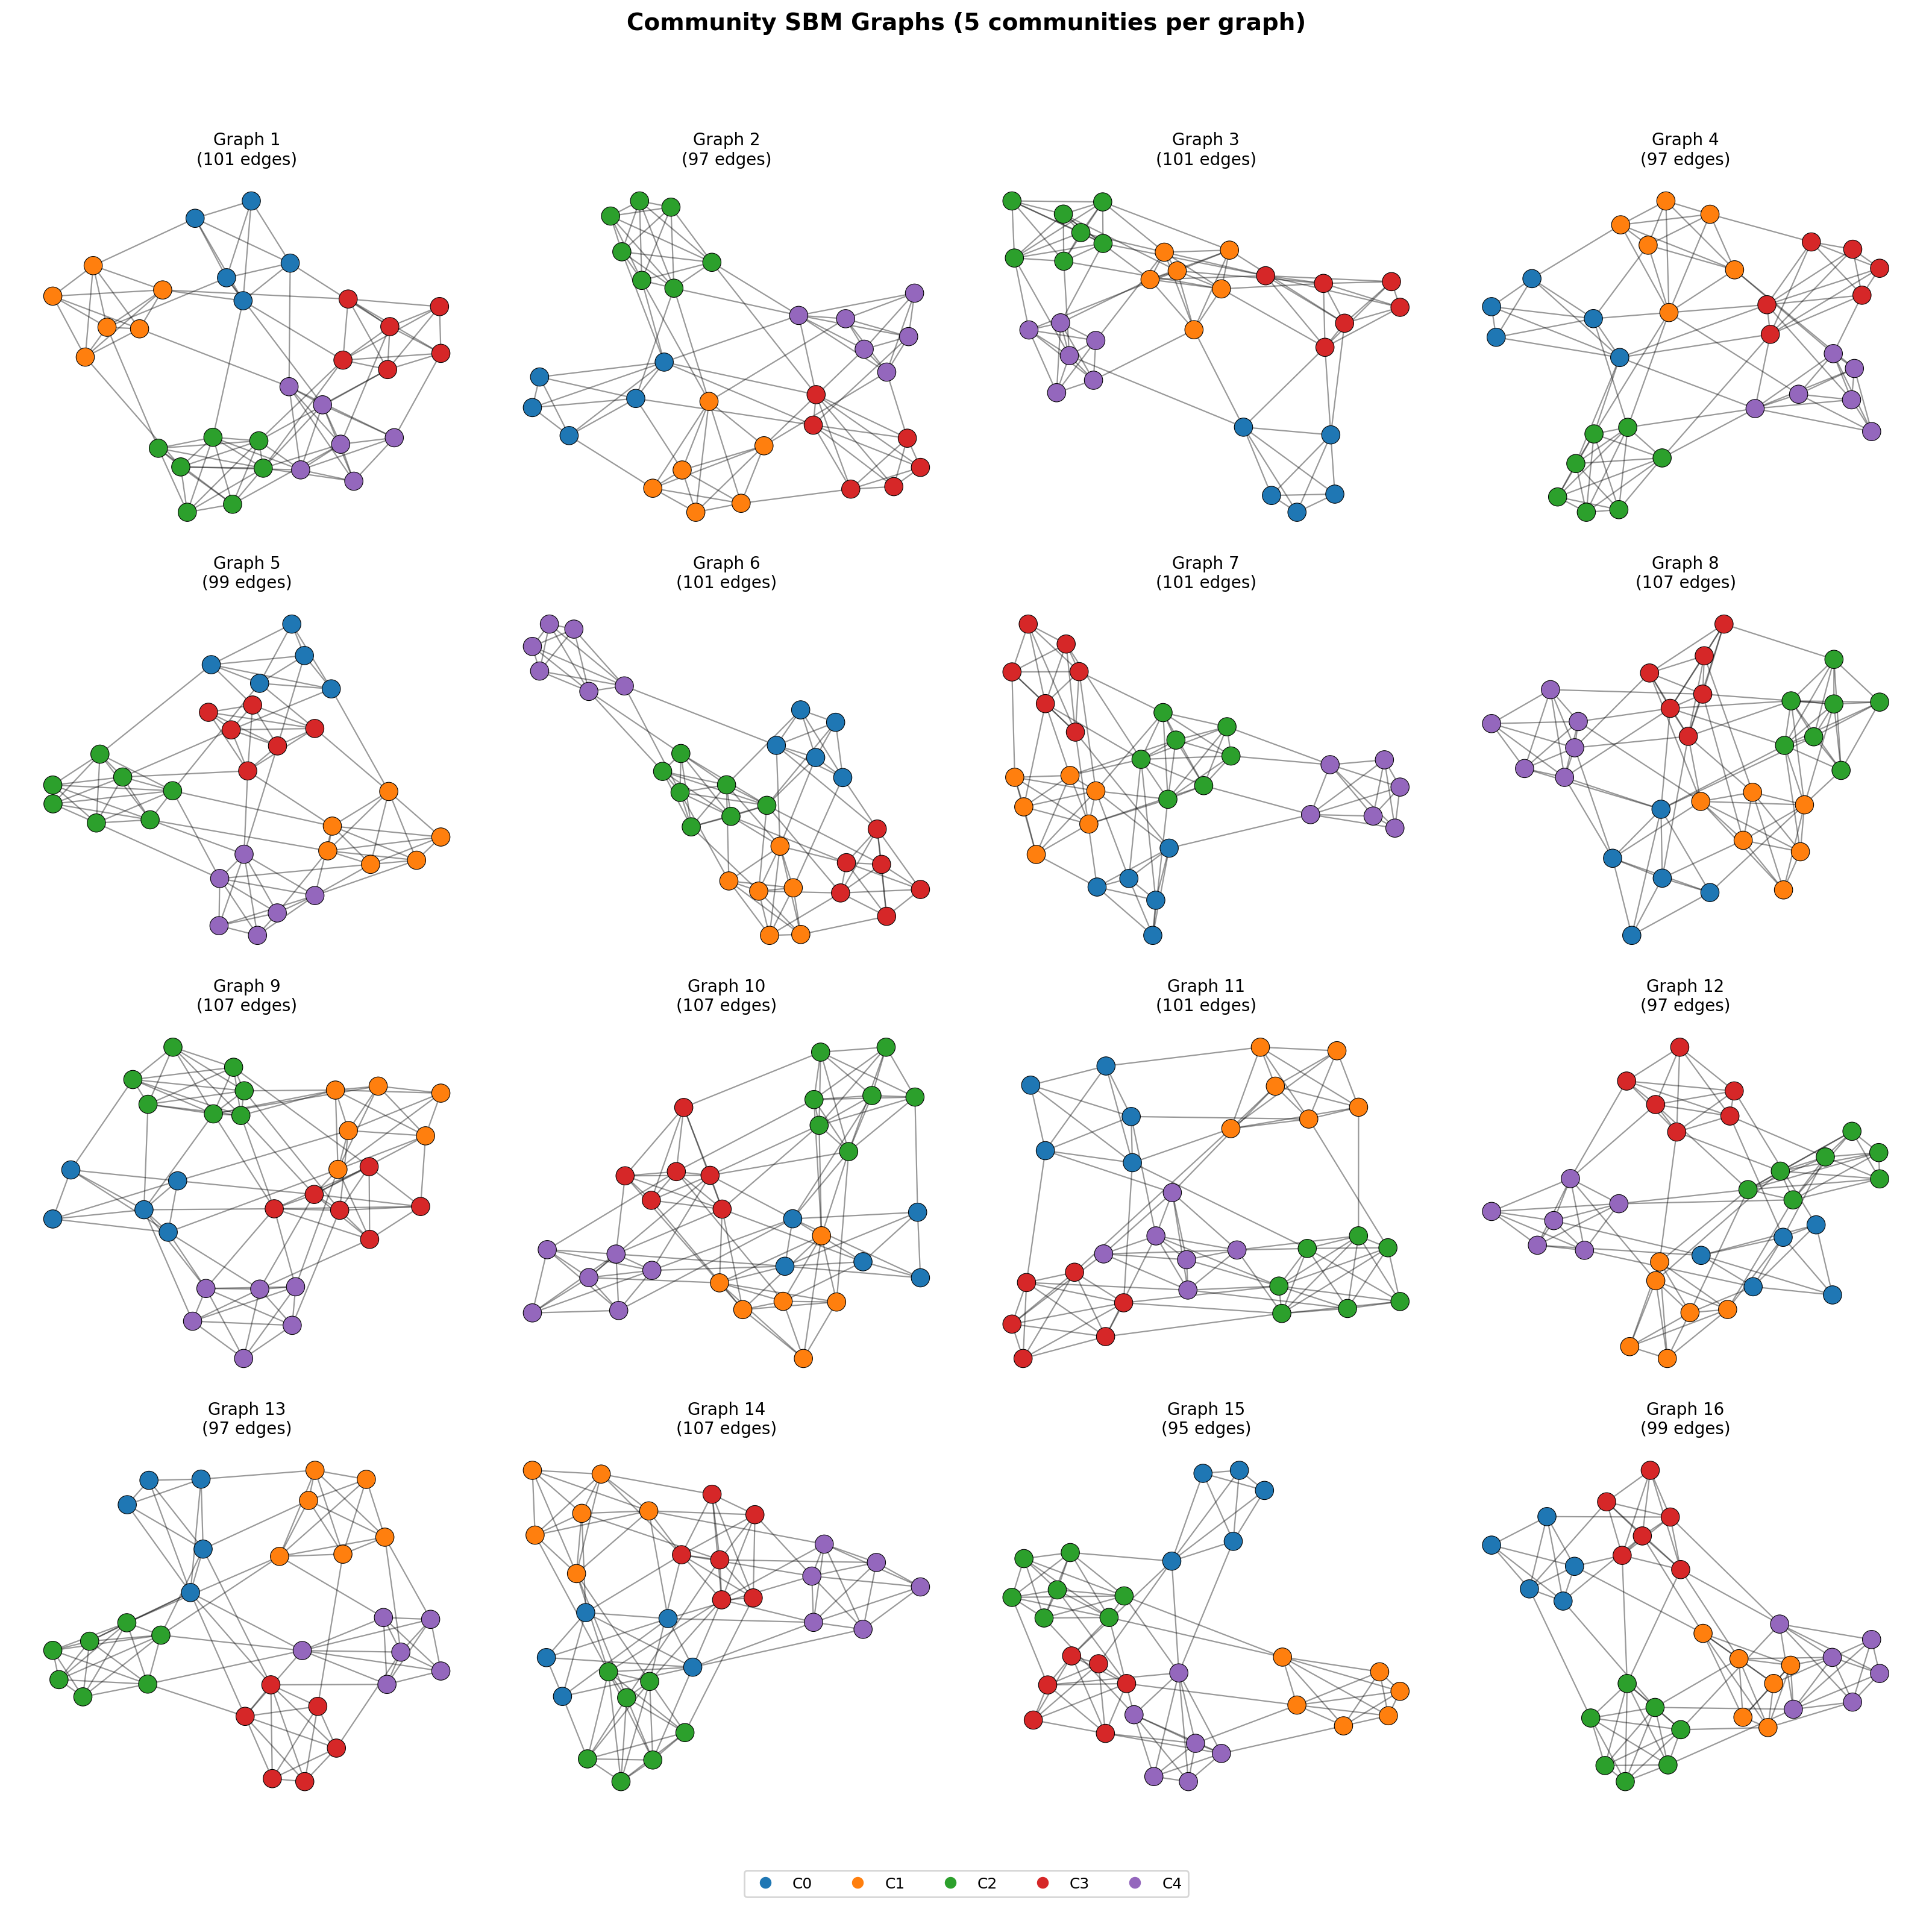

In [ ]:
graphs_chosen = np.random.choice(return_graph, 16)
_ = graph_generation.show_community_graph_grid(graphs_chosen, layout="spring", rows = 4, cols = 4)

In [ ]:
torch.sum(torch.abs(return_graph[-1].adj - return_graph[-2].adj))

tensor(94.)

In [ ]:
print(params_final)

tensor([-2.1748e-02, -4.9085e-04,  1.9779e-03,  2.2800e-04,  7.8033e-03,
         3.6169e-01,  8.5041e-04, -2.5496e+00, -5.7980e-02])


In [ ]:
params_final = params_hist[-1]


params_final[-1] -= 5

return_obs, return_graph = sampler.sample_run(
    graph=graph,
    params=params_final,
    niter=100000,
    save_every=save_every,
    burn_in=0.3
)

final_params = params_hist[-1]

# sampler.param_run already prints accepted/rejected
# but we try to extract them from attributes if present
accepted = getattr(sampler, "accepted_steps", None)
rejected = getattr(sampler, "rejected_samples", None)
acc_rate = (accepted / niter) if accepted is not None else None

100%|██████████| 100000/100000 [00:31<00:00, 3222.90it/s]

number of accepted steps is:  30860
number of rejected samples:  69140
Mean obs:  tensor([19.3230,  2.4158,  2.7285,     nan,  0.0000, 59.8935, 11.9931])


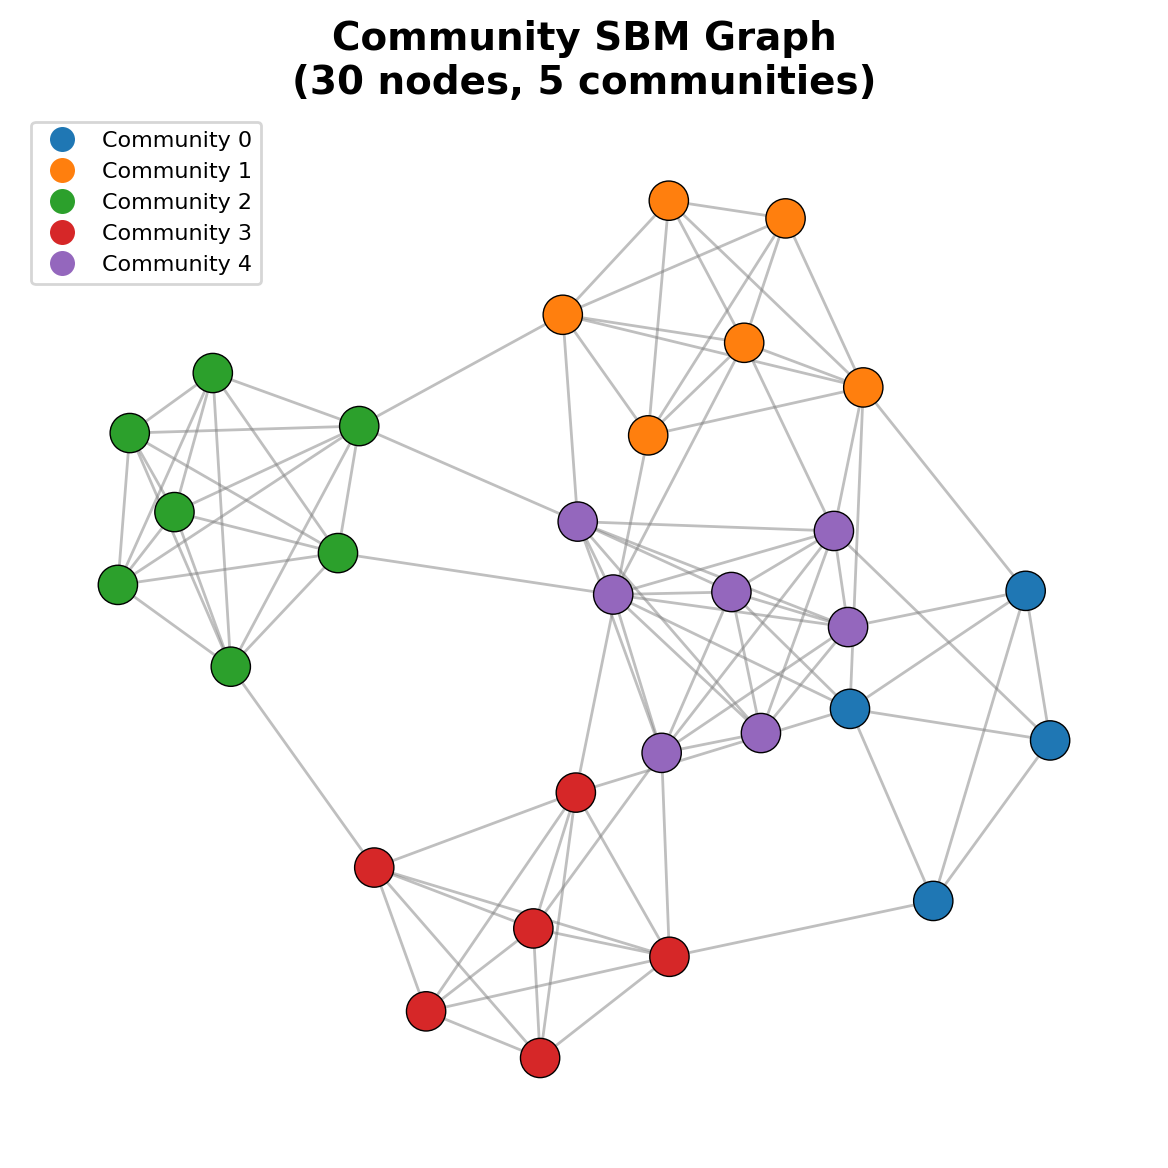

In [ ]:
_ = graph_generation.visualization.show_community_graph(return_graph[-1])

In [8]:

graphs, metadata = graph_generation.community_sbm.load_community_dataset("data/community_sbm/params_2_30_0.8_0.02_8/graphs.pkl")

In [9]:
import pickle, sklearn
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(graphs, test_size=0.2)

In [11]:
with open("data/community_sbm/params_2_30_0.8_0.02_8/train.pkl", "wb") as f:
    pickle.dump(train,f)
with open("data/community_sbm/params_2_30_0.8_0.02_8/test.pkl", "wb") as f:
    pickle.dump(test,f)

In [12]:

graphs, metadata = graph_generation.community_sbm.load_community_dataset("data/community_sbm/params_2_30_0.8_0.02_8/train.pkl")